In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_measurement_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
(last_date, ) = last_measurement_point
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
last_date = last_date.date()
last_year = last_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
data_last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
data_last_year_df = pd.DataFrame(data_last_year, columns=['date', 'prcp'])
data_last_year_df = data_last_year_df.set_index("date")
data_last_year_df = data_last_year_df.dropna(how="any")
print(data_last_year_df)
# Sort the dataframe by date
data_last_year_df = data_last_year_df.sort_values(by=['date'])

            prcp
date            
2016-08-23  0.00
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00
...          ...
2017-08-17  0.13
2017-08-19  0.09
2017-08-21  0.56
2017-08-22  0.50
2017-08-23  0.45

[2021 rows x 1 columns]


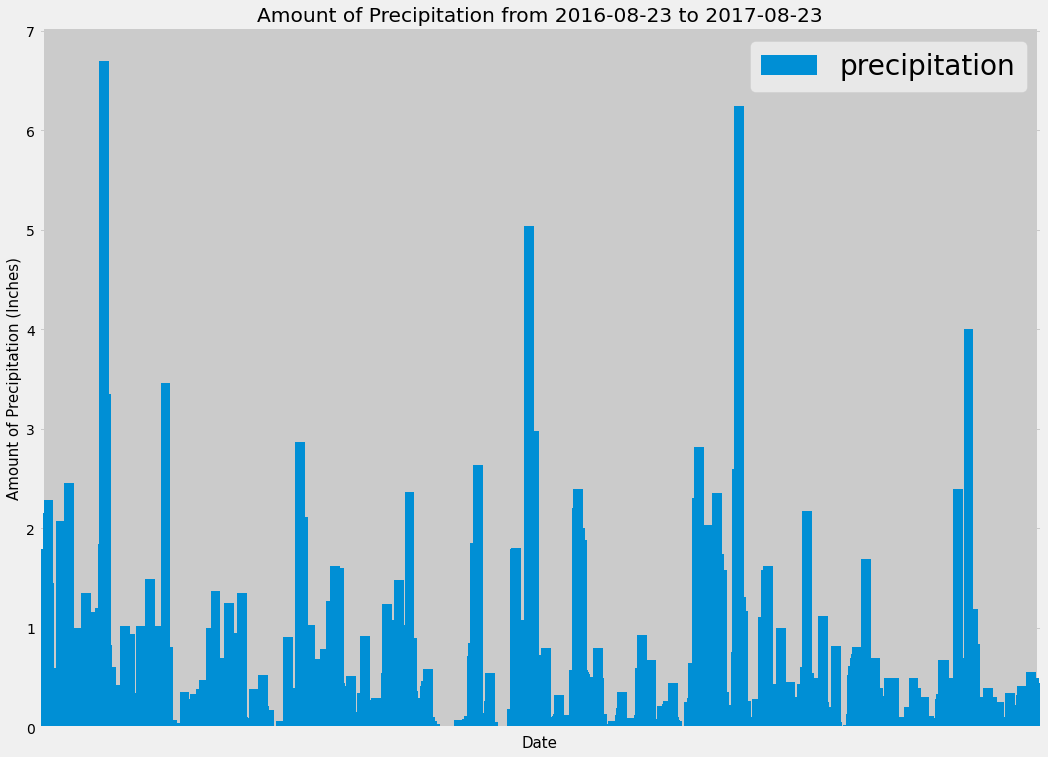

In [16]:
ax = data_last_year_df.plot.bar(figsize=(16,12), width=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_xticklabels([])
ax.set_ylabel("Amount of Precipitation (Inches)", fontsize=15)
ax.set_title(f"Amount of Precipitation from {last_year} to {last_date}")
plt.legend(['precipitation'], fontsize=28)
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.station).count()
number_stations_df = pd.DataFrame({"Number of Stations": number_stations}, index=[0])
number_stations_df

,Number of Stations
0,9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).\
    all()
for station, count in station_count:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = session.query(Measurement.station).\
group_by(Measurement.station).\
order_by(func.count().desc()).\
first()
(most_active_station_id, ) = most_active_station
print(f"The station ID of the most active station is {most_active_station_id}.")
most_active_station_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station_id).\
all()

for lowest_temp, highest_temp, avg_temp in most_active_station_data:
    print(f"The lowest temperature recorded at {most_active_station_id} was {lowest_temp}.")
    print(f"The highest temperature recorded at {most_active_station_id} was {highest_temp}.")
    print(f"The average temperature recorded at {most_active_station_id} was {avg_temp}.")
    


The station ID of the most active station is USC00519281.
The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66378066378067.


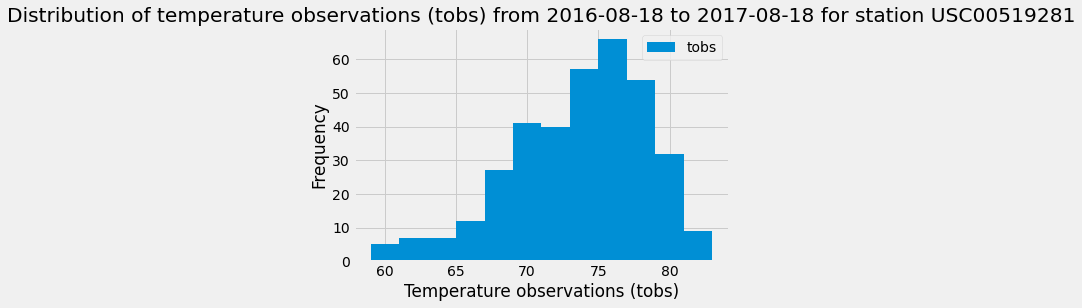

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
measurement_data = session.query(Measurement.date).\
order_by(Measurement.date.desc()).\
filter(Measurement.station == most_active_station_id).first()

(last_date, ) = measurement_data
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
last_date = last_date.date()
last_year = last_date - dt.timedelta(days=365)

data_last_year = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == most_active_station_id).\
filter(Measurement.date >= last_year).all()

data_last_year_df = pd.DataFrame(data_last_year, columns=['date', 'tobs'])
data_last_year_df

plt.hist(data_last_year_df["tobs"], bins=12, label="tobs")
plt.ylabel('Frequency')
plt.xlabel('Temperature observations (tobs)')
plt.title(f"Distribution of temperature observations (tobs) from {last_year} to {last_date} for station {most_active_station_id}")
plt.legend(loc="upper right")
plt.savefig(f"./Images/tobs_histogram_for_station_{most_active_station_id}.png", bbox_inches='tight')
plt.show()